In this notebook I will try to identify which charachteristics of the listed properties have the most significant impact on the price at which the property is exposed (we don't know the actual price at which it is rented out however it should be a good approximation). There is a presumption that the size and location have the most significant influence. But what is more important? Let's figure out.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Here we are downloading our data to df dataframe. And let's look to the columns to find ones appropriate for
# our purposes (location, size (number of bedrooms) and price).
df = pd.read_csv('archive/listings.csv')
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [3]:
# It looks like 'neighbourhood_group_cleansed' column is most appropriate as it gives us location name 
# in mostly aggregated form which is fine for our purposes.
df.neighbourhood_group_cleansed.value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [4]:
# And the column 'bedroom' is what we are looking for. It's a bit strange to see '0' bedrooms options
# however I would assume that these are studio type apartments.
df.bedrooms.value_counts()

1.0    2417
2.0     640
0.0     372
3.0     283
4.0      69
5.0      24
6.0       6
7.0       1
Name: bedrooms, dtype: int64

In [5]:
# And yes, my guess was correct according to the descriptions below.
df[df.bedrooms == 0].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
39,6389657,https://www.airbnb.com/rooms/6389657,20160104002432,2016-01-04,Cute little Seattle Studio!,I love my little studio! My space might be sma...,The patio has a table and chairs and potted pl...,I love my little studio! My space might be sma...,none,"The apartment is in a great location, everythi...",...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,1,1.98
45,6004058,https://www.airbnb.com/rooms/6004058,20160104002432,2016-01-04,LOWER QUEEN ANNE STUDIO W/PATIO,I love my 3rd floor vintage studio apartment w...,-kitchen (stocked with basics & condiments) -b...,I love my 3rd floor vintage studio apartment w...,none,Queen Anne is very Walk-able. From the studio ...,...,9.0,f,NaN,WASHINGTON,f,flexible,f,f,1,2.29
47,8515408,https://www.airbnb.com/rooms/8515408,20160104002432,2016-01-04,Queen Anne Hill Craftsman studio,"Beautiful craftsman style studio, located in o...","The ""Urban Nest"" studio was built with comfort...","Beautiful craftsman style studio, located in o...",none,Queen Anne Hill is centrally located. A very ...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,1.06
50,7772661,https://www.airbnb.com/rooms/7772661,20160104002432,2016-01-04,:: Carriage House :: Queen Anne ::,Charming loft-style studio in an urban garden ...,"This is a detached carriage house, all yours t...",Charming loft-style studio in an urban garden ...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.00


In [6]:
# Now let's make separate dataframe with the columns of interest.
df_analyze = df[['neighbourhood_group_cleansed', 'bedrooms', 'price']]

In [7]:
# Check correctness
df_analyze.head()

,neighbourhood_group_cleansed,bedrooms,price
0,Queen Anne,1.0,$85.00
1,Queen Anne,1.0,$150.00
2,Queen Anne,5.0,$975.00
3,Queen Anne,0.0,$100.00
4,Queen Anne,3.0,$450.00


In [8]:
# Here we need to look at the datatypes and the quantity of missed values.
df_analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  3818 non-null   object 
 1   bedrooms                      3812 non-null   float64
 2   price                         3818 non-null   object 
dtypes: float64(1), object(2)
memory usage: 89.6+ KB


In [9]:
# The 'price' column is an object and we need to convert it to float. Let's do it as following.
df_analyze['price'] = df_analyze['price'].replace('[\$,]', '', regex=True).astype(float)

/var/folders/2z/0v2b22ds6vsd_n4drt7f17bh0000gn/T/ipykernel_25614/2626608951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['price'] = df_analyze['price'].replace('[\$,]', '', regex=True).astype(float)


In [10]:
# Let's check.
df_analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  3818 non-null   object 
 1   bedrooms                      3812 non-null   float64
 2   price                         3818 non-null   float64
dtypes: float64(2), object(1)
memory usage: 89.6+ KB


In [11]:
# Since we have only 6 missing records in 'bedrooms' column, we can just drop them without noticeable impact
# on the accuracy of our analysis.

df_analyze = df_analyze.dropna()

In [12]:
# Now before making the models let's visualise a bit the dependence of the price from 
# the size of apartment (number of bedrooms) and location.
# For this purpose let's group the records by bedrooms to identify average price for each type of apartments.

df_analyze_bedroom = df_analyze.groupby(['bedrooms']).mean()

In [13]:
# Let's check.

df_analyze_bedroom.head()

,price
bedrooms,
0.0,103.548387
1.0,95.706247
2.0,174.062500
3.0,249.530035
4.0,313.695652


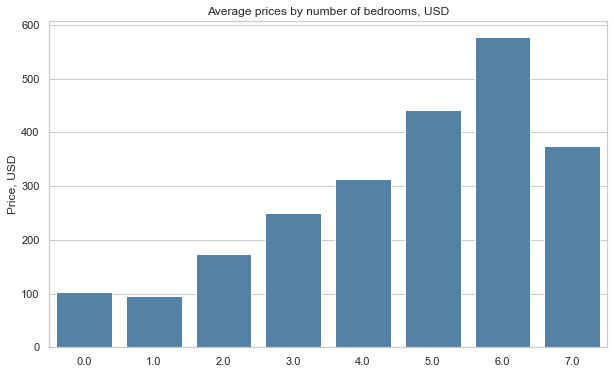

In [16]:
# And now we can draw respective barplot.

plt.figure(figsize=[10, 6]);
sns.set(style="whitegrid");
sns.barplot(data=df_analyze_bedroom, x=df_analyze_bedroom.index, y=df_analyze_bedroom.price, color='steelblue');
# plt.xticks(rotation=20);
plt.ylabel('Price, USD');
plt.xlabel('');
plt.title('Average prices by number of bedrooms, USD');

As we can see above the prices looks really dependent on the number of bedrooms. There is only one 7-bedroom option so it's not representative. And studios are often better located than other types of properties (in downtown or just on the seashore). So this factor can equate their prices with 1-bedroom properties.

In [17]:
# Now let's see the distribution of rent prices by districts. For this purpose I will also group the data. 
df_analyze_location = df_analyze.groupby(['neighbourhood_group_cleansed']).mean()
df_analyze_location.head()

,bedrooms,price
neighbourhood_group_cleansed,,
Ballard,1.434783,124.682609
Beacon Hill,1.262712,94.669492
Capitol Hill,1.139823,130.746903
Cascade,1.101124,140.101124
Central Area,1.436314,128.338753


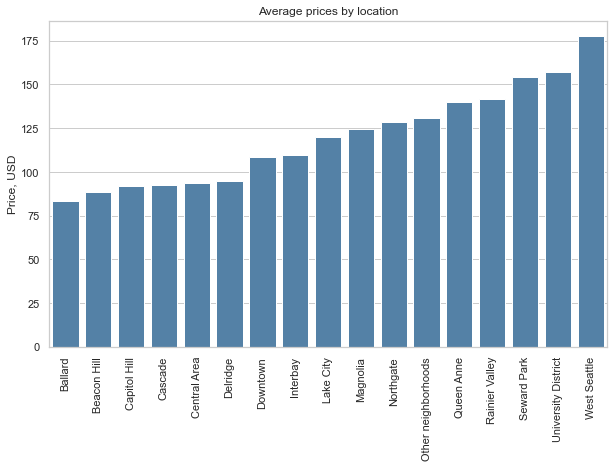

In [18]:
plt.figure(figsize=[10, 6]);
sns.set(style="whitegrid");
sns.barplot(data=df_analyze_location, x=df_analyze_location.index, y=df_analyze_location.price.sort_values(), color='steelblue');
plt.xticks(rotation=90);
plt.ylabel('Price, USD');
plt.xlabel('');
plt.title('Average prices by location');

I don't know the geography of Seattle but it's obvious that there are districts the prices of which differ more than twice. 

In [26]:
# Now let's create the model which will predict prices based on number of bedrooms. And as a result score it.
X = np.array(df_analyze['bedrooms']).reshape(-1, 1)
y = np.array(df_analyze['price']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr_model_bedrooms = LinearRegression()
lr_model_bedrooms.fit(X_train, y_train)
y_pred = lr_model_bedrooms.predict(X_test)

r2_score(y_test, y_pred)

0.3863162766641641

As we can see 38.6% of price variation is defined by number of bedrooms. This is quite significant influence.

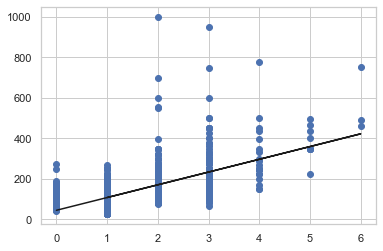

In [20]:
# Let's visualise our model below.

plt.plot(X_test, y_pred, color ='k');
plt.scatter(X_test, y_test, color ='b');

Now let's check how the location affect the price of the property rent. Since the name of location is a nominal categorical value I will apply one-hot encoding using pandas get_dummies method.

In [21]:
df_location = pd.concat([pd.get_dummies(df_analyze['neighbourhood_group_cleansed']), df_analyze.price], axis=1)
df_location.head()

,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,price
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,85.0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,150.0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,975.0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,100.0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,450.0


In [24]:
# Having the encoded dataset we can just use it in our LR model. And let's have a look at R2 score in the end.

X = df_location[df_location.columns[:-1]]
y = df_location['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr_model_location = LinearRegression()
lr_model_location.fit(X_train, y_train)
y_pred = lr_model_location.predict(X_test)

r2_score(y_test, y_pred)

0.04897278485264989

And here is a surprise - less than 5% of price changes is explained by location of the property. This is still noticeable amount however not as dramatical as we could expect.

In [28]:
# And finally let's look at the combined effect of bedrooms and location on the rent price.

X = pd.concat([df_location[df_location.columns[:-1]], df_analyze['bedrooms']], axis=1)
y = df_location['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr_model_location = LinearRegression()
lr_model_location.fit(X_train, y_train)
y_pred = lr_model_location.predict(X_test)

r2_score(y_test, y_pred)

0.45169356447242104

Based on our LR model bedroom and location together contribute more than 45% in the rent price. We should notice that it is higher than simple adding of these 2 effects (38.6 + 4.9 = 43.5%).